In [9]:
!pip install statsmodels
!pip install scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import pandas as pd
from sqlalchemy import create_engine

# --------------------------------------------------------
# 1. CONNECT TO THE DATABASE
# --------------------------------------------------------
host = "anly-615-project-anlyproject.g.aivencloud.com"
port = 23263
user = "avnadmin"
password = "AVNS_uZtAlXsQZVgdnkwXesP"
database = "defaultdb"

# SSL is required for Aiven
connect_args = {"ssl": {"ssl_mode": "REQUIRED"}}

engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}",
    connect_args=connect_args,
    echo=False
)

# --------------------------------------------------------
# 2. READ THE DATA AND CREATE THE COLUMN
# --------------------------------------------------------
table_name = "quarterly_merged_economic_data"

# Read the table into a pandas DataFrame
df = pd.read_sql(f"SELECT * FROM {table_name}", con=engine)

# Ensure the data is sorted by date/quarter so 'consecutive' makes sense
# Assuming 'quarter' is the column name. Adjust if it's 'date' or similar.
df = df.sort_values(by='quarter') 

# Define the logic: GDP negative now AND GDP negative in the previous row
is_negative = df['gdp_pct_change_quarterly'] < 0
df['Recession'] = (is_negative & is_negative.shift(1)).astype(int)
df = df.dropna()
recession_path = 'C:/Users/nurta/Downloads/JHDUSRGDPBR.csv'
df_recession = pd.read_csv(recession_path)

df_recession['observation_date'] = pd.to_datetime(df_recession['observation_date'])
df_recession['quarter'] = df_recession['observation_date'].dt.to_period('Q').astype(str)
df_recession['quarter'] = df_recession['quarter'].apply(lambda x: x[:4] + '-' + x[4:])
df_recession.head(5)


,observation_date,JHDUSRGDPBR,quarter
0,2001-01-01,1,2001-Q1
1,2001-04-01,1,2001-Q2
2,2001-07-01,1,2001-Q3
3,2001-10-01,0,2001-Q4
4,2002-01-01,0,2002-Q1


In [13]:

df = pd.merge(df, df_recession['quarter'], on='quarter', how='left')
df = df[df['quarter'] >= '2001-Q3'].copy()
df.head(5)


,quarter,avg_sp500_close,gdp_pct_change_quarterly,avg_yield_1mo,avg_yield_5yr,avg_yield_spread,avg_consumer_sentiment,avg_oil,Recession
0,2001-Q3,1153.71,0.5,3.18,4.38,1.20,88.57,26.67,0
1,2001-Q4,1115.37,0.2,2.00,4.08,2.08,85.13,20.40,0
2,2002-Q1,1132.21,1.3,1.73,4.46,2.73,93.13,21.66,0
3,2002-Q2,1070.15,1.3,1.73,4.45,2.72,94.10,26.25,0
4,2002-Q3,895.49,2.1,1.69,3.36,1.67,87.27,28.34,0


Optimization terminated successfully.
         Current function value: 0.129828
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              Recession   No. Observations:                   94
Model:                          Logit   Df Residuals:                       90
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.3752
Time:                        14:20:57   Log-Likelihood:                -12.204
converged:                       True   LL-Null:                       -19.534
Covariance Type:            nonrobust   LLR p-value:                  0.002131
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     15.7008      6.152      2.552      0.011       3.644      

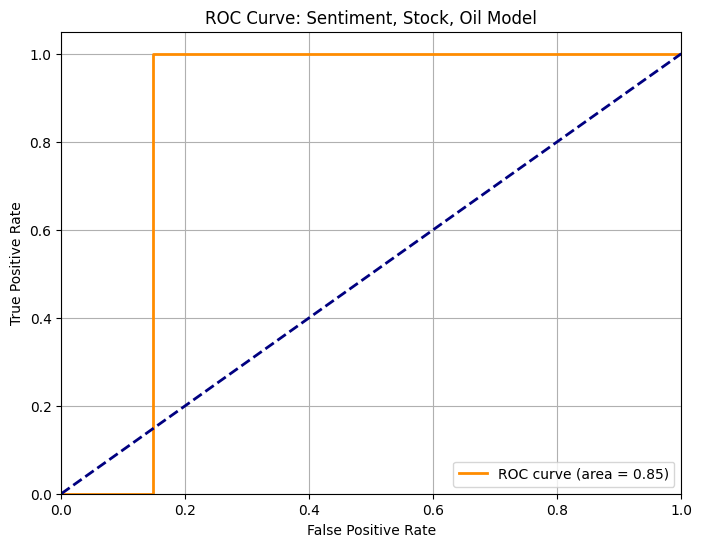

In [14]:

# 3. Define Predictors (X) - REMOVING the GDP variable
# We keep only the market/sentiment indicators
X = df[['avg_sp500_close', 'avg_consumer_sentiment', 'avg_oil']]
y = df['Recession']

# 4. Run Statsmodels (for p-values)
X_const = sm.add_constant(X)
try:
    logit_model = sm.Logit(y, X_const)
    result = logit_model.fit()
    print(result.summary())
except Exception as e:
    print(e)

# 5. Run Sklearn (for accuracy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
sk_model = LogisticRegression(max_iter=1000)
sk_model.fit(X_train, y_train)

print(f"Accuracy: {sk_model.score(X_test, y_test):.2%}")
print(f"Model 1 AIC (Sentiment, Stock, Oil): {result.aic:.4f}")
# 1. Get predicted probabilities for the positive class (Recession = 1)
y_probs = sk_model.predict_proba(X_test)[:, 1]
# 2. Calculate FPR, TPR, and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

    # 3. Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Sentiment, Stock, Oil Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('model1_roc_curve.png')
plt.show()





Optimization terminated successfully.
         Current function value: 0.204150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204150
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Recession   No. Observations:                   94
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                            1
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                 0.01760
Time:                        14:23:14   Log-Likelihood:                -19.190
converged:                       True   LL-Null:                       -19.534
Covariance Type:            nonrobust   LLR p-value:                    0.4070
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

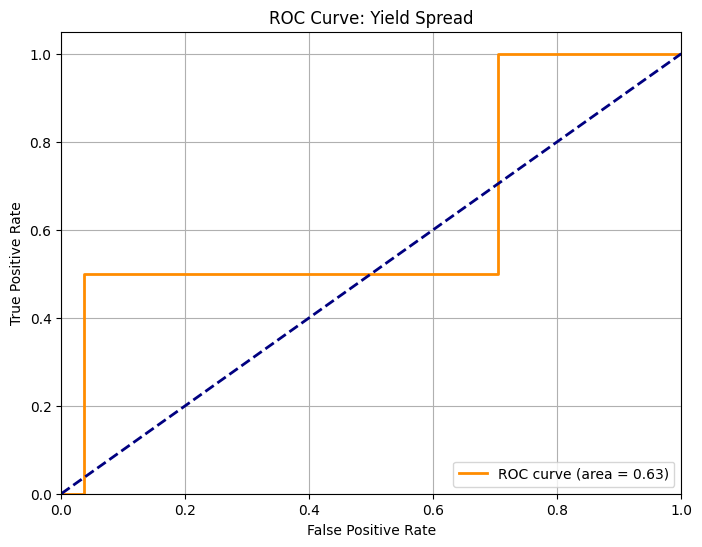

In [16]:

# Just the Yield Curve as Predictor
X = df[['avg_yield_spread']]
y = df['Recession']

# 3. Run Model
X_const = sm.add_constant(X)
model = sm.Logit(y, X_const).fit()

# 4. Run Statsmodels (for p-values)
X_const = sm.add_constant(X)
try:
    logit_model = sm.Logit(y, X_const)
    result = logit_model.fit()
    print(result.summary())
except Exception as e:
    print(e)

# 5. Run Sklearn (for accuracy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
sk_model = LogisticRegression(max_iter=1000)
sk_model.fit(X_train, y_train)
print(f"Model 2 AIC (Yield Spread Only): {result.aic:.4f}")
print(f"Accuracy: {sk_model.score(X_test, y_test):.2%}")
y_probs = sk_model.predict_proba(X_test)[:, 1]
# 2. Calculate FPR, TPR, and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

    # 3. Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Yield Spread')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('model1_roc_curve.png')
plt.show()

Optimization terminated successfully.
         Current function value: 0.127912
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              Recession   No. Observations:                   94
Model:                          Logit   Df Residuals:                       89
Method:                           MLE   Df Model:                            4
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.3845
Time:                        14:25:45   Log-Likelihood:                -12.024
converged:                       True   LL-Null:                       -19.534
Covariance Type:            nonrobust   LLR p-value:                  0.004659
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     15.1263      6.322      2.392      0.017       2.735      

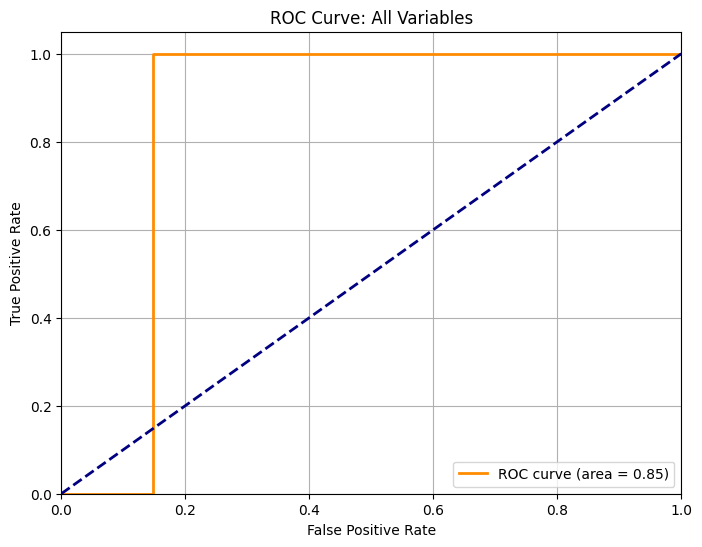

In [17]:

# 3. Define Predictors (X) - REMOVING the GDP variable
# We keep only the market/sentiment indicators
X = df[['avg_sp500_close', 'avg_consumer_sentiment', 'avg_oil', 'avg_yield_spread']]
y = df['Recession']

# 4. Run Statsmodels (for p-values)
X_const = sm.add_constant(X)
try:
    logit_model = sm.Logit(y, X_const)
    result = logit_model.fit()
    print(result.summary())
except Exception as e:
    print(e)

# 5. Run Sklearn (for accuracy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
sk_model = LogisticRegression(max_iter=1000)
sk_model.fit(X_train, y_train)

print(f"Accuracy: {sk_model.score(X_test, y_test):.2%}")
print(f"Model 1 AIC (Sentiment, Stock, Oil): {result.aic:.4f}")

# 1. Get predicted probabilities for the positive class (Recession = 1)
y_probs = sk_model.predict_proba(X_test)[:, 1]
# 2. Calculate FPR, TPR, and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

    # 3. Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: All Variables')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('model1_roc_curve.png')
plt.show()


